In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


# Explain design2data

This notebook aims to explain the reasoning behind the design2data method of the BED_discrete class and how to use it for your experimental design problem. In short it aims to make the class as simple as possible while giving the user full control for more complex designs. We will look at a number of different examples to explain how to use design2data for various populare setups in seismic experiments.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import h5py


import torch
import torch.distributions as dist 

Consider the following simple experiment. The aim of the experiment is to estimate the bulk velocity of a rock sample (grey rectangle). To this end receivers can be placed on the sides of the sample at different offsets (red triangles). Using a seismic source (red star), the bulk velocity can be calculated using the first arrival paths (grey lines) of the induced seismic phases.

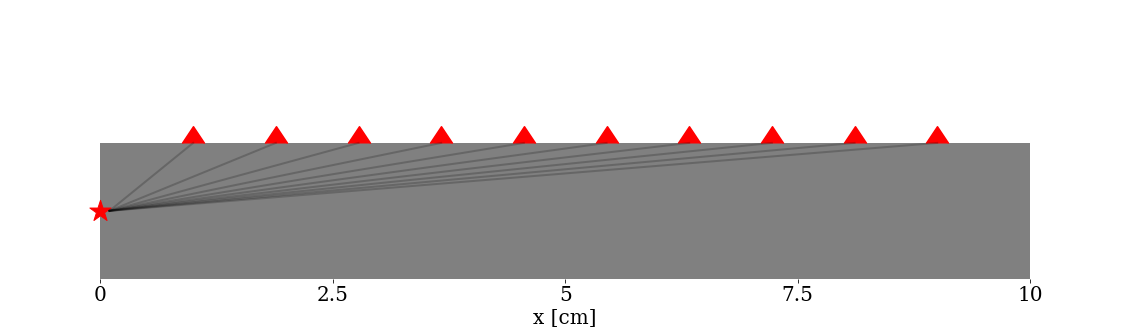

In [3]:
# draw a grey rectangle with matplotlib
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(20,5))

ax.add_patch(
    patches.Rectangle((0, 0), 10, 1, facecolor="gray", zorder=1)
)

ax.set_xlim(-1, 11)
ax.set_ylim(0, 2)

ax.set_xticks(np.linspace(0, 10, 5))
ax.set_xticklabels(['0', '2.5', '5', '7.5', '10'], fontsize=20)
ax.set_xlabel(r'x [cm]', fontsize=20)

ax.yaxis.set_visible(False)
for axis in ['top', 'bottom', 'left','right']:
    ax.spines[axis].set_linewidth(0)

ax.scatter(0.0, 0.5, s=500, marker='*', zorder=12, color='r')
for rec in np.linspace(1, 9, 10):
    ax.scatter(rec, 1, s=500, marker=10, zorder=12, color='r')
    ax.plot([0.1, rec], [0.5, 1], color='k', linewidth=2, zorder=12, alpha=0.2)


plt.show()

To solve the experimental design problem we now need three ingredients:

1. A *forward function* that takes a experimental design (here list of receiver offsets) and returns the measured data (here straight ray travel times). This forward function also needs to encode the likeliehood of observing a certain datum which is here simply the measurment uncertainty.
2. A model prior distribution, which encodes our prior knowledge about the prior velocity. Here this could be a Gaussian with the mean corresponding to a typical velocity in the type of rock we use and a empirical standar deviation.
3. The so-called design space, encoding all possible experiments we can conduct, which is here just a list of offset values at which receivers can be placed.

In [4]:
def forward_function(bulk_velocity, offset):    
    # since we know the source is at x=0, we can calculate the distance to the receiver directly by using pythagoras theorem
    return torch.sqrt(0.5**2 + offset**2) / bulk_velocity

In [5]:
n_prior = int(1e4)

bulk_velocity_prior = dist.Independent(dist.Normal(torch.tensor([4.5,]), torch.tensor([0.5,])), 1)
bulk_velocity_prior_samples = bulk_velocity_prior.sample([n_prior])

In [6]:
def data_likelihood(samples, **kwargs):

    torch.manual_seed(0)
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor(0.1)), 1)
    
    return data_likelihood

In [7]:
n_design_points = 10
design_names = [str(i) for i in range(n_design_points)]
offsets      = torch.linspace(1, 9, n_design_points)

filename_base_case = 'data/forward_model_data.h5'
dataset = 'data'

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'file': filename_base_case, 'dataset': dataset, 'cost': 1.0}

In [8]:
with h5py.File(filename_base_case, 'w') as f:
    data = f.create_dataset("data", (n_prior, n_design_points, 1))
    
    for design in design_dicts:
                
        data[:, design_dicts[design]['index']] = forward_function(bulk_velocity_prior_samples, design_dicts[design]['offset'])
        
with h5py.File(filename_base_case, 'r') as f:
    data = torch.from_numpy(f['data'][:])

In [9]:
from geobed.discrete import BED_discrete

BED_class = BED_discrete(
    design_dicts, data_likelihood,
    prior_samples=bulk_velocity_prior_samples, prior_dist=bulk_velocity_prior, design2data='lookup_1to1_fast')

/home/dstrutz/sshfs/Libs/GeoBED/geobed/discrete/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


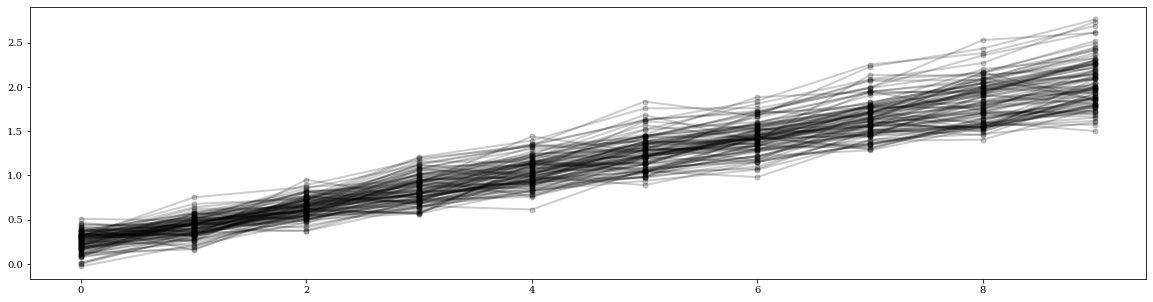

In [10]:
design_points = [n for n in design_dicts]
# design_points = ['0', '2', '2', '3', '4', '2']

noisy_data = BED_class.get_likelihood_samples(design_points, n_samples=1000)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(noisy_data[:100, :].T, '-o', color='k', markersize=5, label='data', linewidth=2, alpha=0.2)
plt.show()

In [11]:
optimal_design, info_dict = BED_class.find_optimal_design(
    design_point_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    design_budget=4,
    eig_method='dn',
    eig_method_kwargs={'N': 1000},
    opt_method='iterative_construction',
    opt_method_kwargs={'allow_repeats': True, 'random_seed':0},
    num_workers=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
print(optimal_design)

['9', '9', '9', '9']


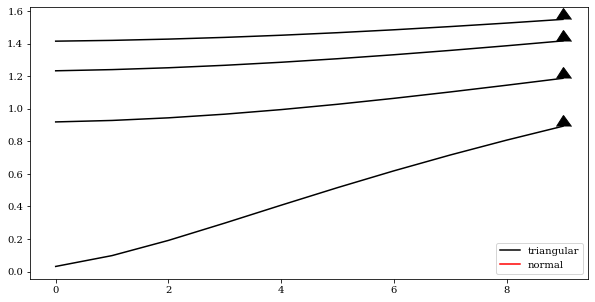

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(1, len(info_dict)+1):
    ax.plot(range(len(info_dict[i]['eig'])), info_dict[i]['eig'], color='k')
    ax.plot(
        [int(optimal_design[i-1])],
        info_dict[i]['eig'][int(optimal_design[i-1])],
        marker=10, markersize=15, color='k')


plt.plot([], [], 'k', label='triangular')
plt.plot([], [], 'r', label='normal')

ax.legend()

plt.show()

## Case 2

The above case is the simplest case and we now go on to more complex cases. In the following case we assume that instead of just measuring the first arrival time it is possible to also measure a number other first arrivals corresponding to different seismic phases such as the S wave arrival time. The effect for the optimal design is that each receiver now collects a data vector with a length corresponding to the number of phase arrivals instead of a single scalar value.

In [14]:
def forward_function_multiple_phases(bulk_velocity, offset):    
    # since we know the source is at x=0, we can calculate the distance to the receiver directly by using pythagoras theorem
    return torch.sqrt(0.5**2 + offset**2) / (bulk_velocity * torch.tensor([1.0, 0.5, 0.3]))

In [15]:
n_design_points = 10
design_names = [str(i) for i in range(n_design_points)]
offsets      = torch.linspace(1, 9, n_design_points)

filename_multiple_phases = 'data/forward_model_data_multiple_phases.h5'
dataset = 'data'

design_dicts_multiple_phases = {}

for i, name in enumerate(design_names):
    design_dicts_multiple_phases[name] = {'index': i, 'offset': offsets[i], 'file': filename_multiple_phases, 'dataset': dataset, 'cost': 1.0}

In [16]:
num_phases = 3

with h5py.File(filename_multiple_phases, 'w') as f:
    data_multiple_phases = f.create_dataset("data", (n_prior, n_design_points, num_phases))
    
    for design in design_dicts:
                
        data_multiple_phases[:, design_dicts[design]['index']] = forward_function_multiple_phases(bulk_velocity_prior_samples, design_dicts[design]['offset'])
        
with h5py.File(filename_multiple_phases, 'r') as f:
    data_multiple_phases = torch.from_numpy(f['data'][:])

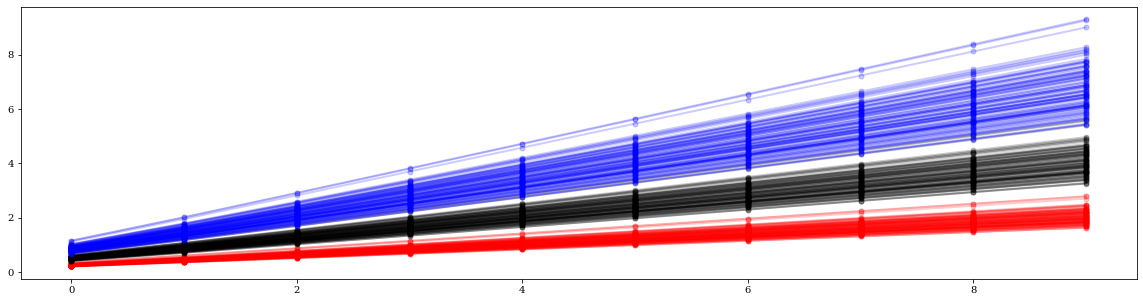

In [17]:
fig, ax = plt.subplots(figsize=(20,5))

colors = ['r', 'k', 'b']

for i in range(num_phases):
    ax.plot(data_multiple_phases[:100, :, i].T, '-o', markersize=5, label='data', linewidth=2, alpha=0.2, color=colors[i])
plt.show()

In [18]:
BED_class_multiple_phases = BED_discrete(design_dicts_multiple_phases, data_likelihood, prior_samples=bulk_velocity_prior_samples, prior_dist=bulk_velocity_prior)

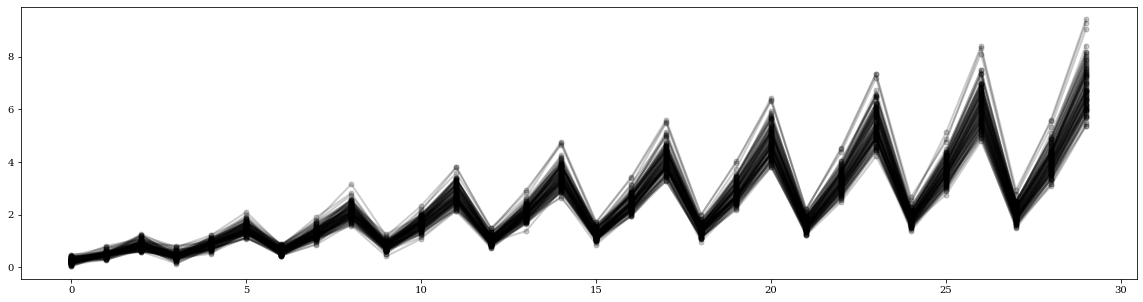

In [19]:
design_points = [n for n in design_dicts]

noisy_data_multiple_phases = BED_class_multiple_phases.get_likelihood_samples(design_points)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(noisy_data_multiple_phases[:100, :].T, '-o', color='k', markersize=5, label='data', linewidth=2, alpha=0.2)
plt.show()

In [20]:
optimal_design_multiple_phases, info_dict_multiple_phases = BED_class_multiple_phases.find_optimal_design(
    design_point_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    design_budget=4,
    eig_method='dn',
    eig_method_kwargs={'N': 1000},
    opt_method='iterative_construction',
    opt_method_kwargs={'allow_repeats': False},
    num_workers=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
print(optimal_design_multiple_phases)

['9', '8', '7', '6']


The above approach also works for receivers returning different different length outputs.

# Case 3

In some cases the measuments we taka are not directly related to a receiver but depend on the general design geometry. In this case the default data2design method is not sufficient but a costum one needs to be defined. Before explaining how to do that lets first go into more detail on the new experimental setup.

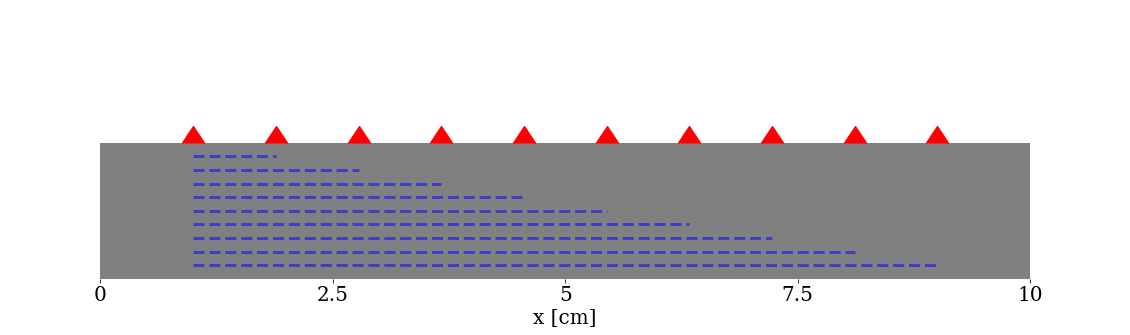

In [22]:
# draw a grey rectangle with matplotlib
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(20,5))

ax.add_patch(
    patches.Rectangle((0, 0), 10, 1, facecolor="gray", zorder=1)
)

ax.set_xlim(-1, 11)
ax.set_ylim(0, 2)

ax.set_xticks(np.linspace(0, 10, 5))
ax.set_xticklabels(['0', '2.5', '5', '7.5', '10'], fontsize=20)
ax.set_xlabel(r'x [cm]', fontsize=20)

ax.yaxis.set_visible(False)
for axis in ['top', 'bottom', 'left','right']:
    ax.spines[axis].set_linewidth(0)

for i, rec in enumerate(np.linspace(1, 9, 10)):
    ax.scatter(rec, 1, s=500, marker=10, zorder=12, color='r')
    if i == 0:
        continue
    ax.plot([1.0, rec], [1.0-0.1*i, 1.0-0.1*i], color='b', linewidth=3, zorder=12, alpha=0.5, linestyle='--')


plt.show()

This mean that we first have to define a new forward function.

In [23]:
n_design_points = 10
design_names = [str(i) for i in range(n_design_points)]
offsets      = torch.linspace(1, 9, n_design_points)

filename_interstation_case = 'data/forward_model_data_interstation_design.h5'
dataset = 'data'

design_dicts_interstation_case = {}

for i, name in enumerate(design_names):
    design_dicts_interstation_case[name] = {'index': i, 'offset': offsets[i], 'file': filename_interstation_case, 'dataset': dataset, 'cost': 1.0}

In [24]:
with h5py.File(filename_interstation_case, 'w') as f:
    data_interstation_case = f.create_dataset("data", (n_prior, n_design_points * (n_design_points-1) // 2, 1))
    
    tril_indices = np.tril_indices(n_design_points, -1)

    for i in range(n_design_points * (n_design_points-1) // 2):
        
        interstation_offset = offsets[tril_indices[1][i]] - offsets[tril_indices[0][i]]
        
        data_interstation_case[:, i] = forward_function(bulk_velocity_prior_samples, interstation_offset)
        
with h5py.File(filename_interstation_case, 'r') as f:
    data_interstation_case = torch.from_numpy(f['data'][:])

In [25]:
BED_class_interstation_case = BED_discrete(design_dicts_interstation_case, data_likelihood, prior_samples=bulk_velocity_prior_samples, prior_dist=bulk_velocity_prior, design2data='lookup_interstation_design')

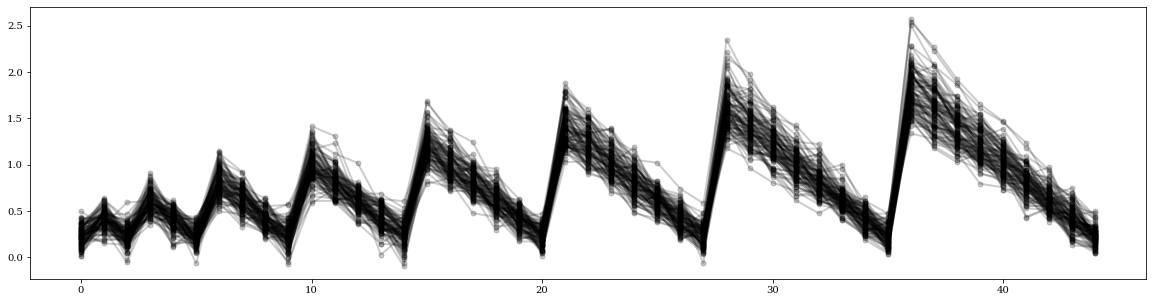

In [26]:
noisy_data = BED_class_interstation_case.get_likelihood_samples(design_points)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(noisy_data[:100, :].T, '-o', color='k', markersize=5, label='data', linewidth=2, alpha=0.2)
plt.show()

In [27]:
optimal_design_interstation_cases, info_dict_interstation_case = BED_class_interstation_case.find_optimal_design(
    design_point_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    design_budget=4,
    eig_method='dn',
    eig_method_kwargs={'N': 1000},
    opt_method='iterative_construction',
    opt_method_kwargs={'initial_design':['0'], 'allow_repeats': False},
    num_workers=1,
    )

  0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
print(optimal_design_interstation_cases)

['0', '9', '8', '1', '2']


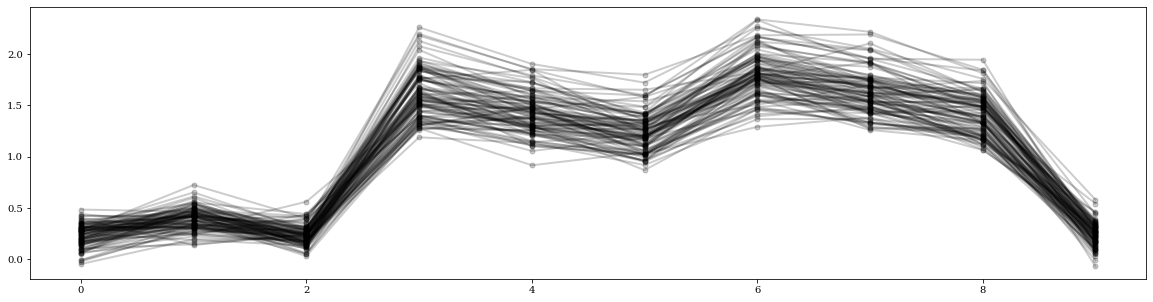

In [29]:
noisy_data = BED_class_interstation_case.get_likelihood_samples(optimal_design_interstation_cases)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(noisy_data[:100, :].T, '-o', color='k', markersize=5, label='data', linewidth=2, alpha=0.2)
plt.show()

# Case 4

In some cases it is better (e.g.: more memory efficient) to calculate the data on the fly using the forward function itself. This can also be incoporated using the design2data functionality.

In [30]:
design_dicts_constructor_case = {}

for i, name in enumerate(design_names):
    design_dicts_constructor_case[name] = {'index': i, 'offset': offsets[i], 'forward_function': forward_function, 'cost': 1.0}

In [31]:
def constructor_1to1_design(self, name_list, n_samples):
    
    name_list = list(dict.fromkeys(name_list)) # remove duplicates 
    # list(set(name_list)) destroys the order of the list
    design_dicts_list = [self.design_dicts[n] for n in name_list]
        
    data = torch.zeros((n_samples, len(name_list), 1))
                
    for i, d_meta in enumerate(design_dicts_list):
        data[:, i, :] = d_meta['forward_function'](bulk_velocity_prior_samples[:n_samples], d_meta['offset'])

    return data.flatten(start_dim=-2)

In [32]:
from geobed import BED_discrete

BED_class_constructor = BED_discrete(design_dicts_constructor_case, data_likelihood, prior_samples=bulk_velocity_prior_samples, prior_dist=bulk_velocity_prior,
                                     design2data=constructor_1to1_design)

torch.Size([10000, 10])


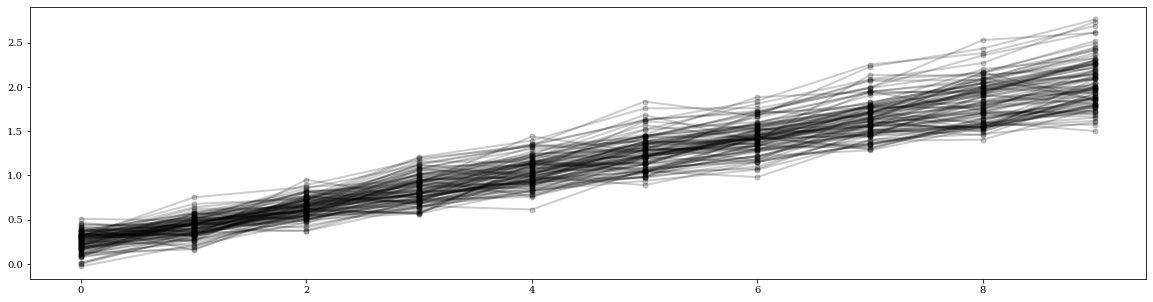

In [33]:
design_points = [n for n in design_dicts]

noisy_data = BED_class_constructor.get_likelihood_samples(design_points)

print(noisy_data.shape)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(noisy_data[:100, :].T, '-o', color='k', markersize=5, label='data', linewidth=2, alpha=0.2)
plt.show()

In [34]:
optimal_design, info_dict = BED_class.find_optimal_design(
    design_point_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    design_budget=4,
    eig_method='dn',
    eig_method_kwargs={'N': 1000},
    opt_method='iterative_construction',
    opt_method_kwargs={'allow_repeats': False},
    num_workers=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
print(optimal_design)

['9', '8', '7', '6']
